<a href="https://colab.research.google.com/github/RobertoAlessandri/CNN_DOA/blob/main/FeatureExtraction_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import IPython.display as ipd
from pathlib import Path
import sklearn
plt.style.use('seaborn')

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)

2.8.0


In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
%cd /content/drive/MyDrive/Github/CNN_DOA/Dataset/TRAIN


# Get a list of all audio files and get the class label for each file
audiofiles = [str(file) for file in Path().glob('SA*.wav')]
labels = []
for i,file in enumerate(audiofiles):
  fileid = file.split('.wav')[-2]
  target = fileid.split('-')[-1]
  labels.append(int(target))

/content/drive/MyDrive/Github/CNN_DOA/Dataset/TRAIN


In [70]:
audiofiles

['SA1400-0-350-2-7.wav',
 'SA1401-1-350-2-7.wav',
 'SA1402-2-350-2-7.wav',
 'SA1403-3-350-2-7.wav',
 'SA1404-0-351-7-21.wav',
 'SA1405-1-351-7-21.wav',
 'SA1406-2-351-7-21.wav',
 'SA1407-3-351-7-21.wav',
 'SA1408-0-352-4-13.wav',
 'SA1409-1-352-4-13.wav',
 'SA1410-2-352-4-13.wav',
 'SA1411-3-352-4-13.wav',
 'SA1412-0-353-4-12.wav',
 'SA1413-1-353-4-12.wav',
 'SA1414-2-353-4-12.wav',
 'SA1415-3-353-4-12.wav',
 'SA1416-0-354-8-23.wav',
 'SA1417-1-354-8-23.wav',
 'SA1418-2-354-8-23.wav',
 'SA1419-3-354-8-23.wav',
 'SA1420-0-355-1-4.wav',
 'SA1421-1-355-1-4.wav',
 'SA1422-2-355-1-4.wav',
 'SA1423-3-355-1-4.wav',
 'SA1424-0-356-6-18.wav',
 'SA1425-1-356-6-18.wav',
 'SA1426-2-356-6-18.wav',
 'SA1427-3-356-6-18.wav',
 'SA1428-0-357-7-21.wav',
 'SA1429-1-357-7-21.wav',
 'SA1430-2-357-7-21.wav',
 'SA1431-3-357-7-21.wav',
 'SA1432-0-358-9-28.wav',
 'SA1433-1-358-9-28.wav',
 'SA1434-2-358-9-28.wav',
 'SA1435-3-358-9-28.wav',
 'SA1436-0-359-8-23.wav',
 'SA1437-1-359-8-23.wav',
 'SA1438-2-359-8-23.

In [71]:
print(len(audiofiles))

4800


In [72]:
class_34 = [str(file) for file in Path().glob('SA*-34.wav')]
class_15 = [str(file) for file in Path().glob('SA*-15.wav')]

print('Number of class_0 examples: {}'.format(len(class_34)))
print('Number of class_1 examples: {}'.format(len(class_15)))

print('class_34 files:')
print(*class_34, sep='\n')


print('class_15 files:')
print(*class_15, sep='\n')

Number of class_0 examples: 480
Number of class_1 examples: 240
class_34 files:
SA1448-0-362-11-34.wav
SA1449-1-362-11-34.wav
SA1450-2-362-11-34.wav
SA1451-3-362-11-34.wav
SA1460-0-365-11-34.wav
SA1461-1-365-11-34.wav
SA1462-2-365-11-34.wav
SA1463-3-365-11-34.wav
SA1528-0-382-11-34.wav
SA1529-1-382-11-34.wav
SA1530-2-382-11-34.wav
SA1531-3-382-11-34.wav
SA1540-0-385-11-34.wav
SA1541-1-385-11-34.wav
SA1542-2-385-11-34.wav
SA1543-3-385-11-34.wav
SA1608-0-402-11-34.wav
SA1609-1-402-11-34.wav
SA1610-2-402-11-34.wav
SA1611-3-402-11-34.wav
SA1620-0-405-11-34.wav
SA1621-1-405-11-34.wav
SA1622-2-405-11-34.wav
SA1623-3-405-11-34.wav
SA1688-0-422-11-34.wav
SA1689-1-422-11-34.wav
SA1690-2-422-11-34.wav
SA1691-3-422-11-34.wav
SA1700-0-425-11-34.wav
SA1701-1-425-11-34.wav
SA1702-2-425-11-34.wav
SA1703-3-425-11-34.wav
SA1768-0-442-11-34.wav
SA1769-1-442-11-34.wav
SA1770-2-442-11-34.wav
SA1771-3-442-11-34.wav
SA1780-0-445-11-34.wav
SA1781-1-445-11-34.wav
SA1782-2-445-11-34.wav
SA1783-3-445-11-34.wav


## Flow:
1) microphone signals

2) STFT 

3) Active SI estimation

4) Whitening weighting

In [73]:
print(len(class_15))
print(type(class_15))
print(len(class_15[0]))
print(type(class_15[0]))

240
<class 'list'>
21
<class 'str'>


In [74]:
sr = 16000

def stringToSignal(listclass):
  mic_0 = []
  mic_1 = []
  mic_2 = []
  mic_3 = []
  for i in range(len(listclass)):
    if listclass[i].find("-0-", 3, 10) != -1 :
      mic_0.append(listclass[i])
    if listclass[i].find("-1-", 3, 10) != -1 :
      mic_1.append(listclass[i])
    if listclass[i].find("-2-", 3, 10) != -1 :
      mic_2.append(listclass[i])
    if listclass[i].find("-3-", 3, 10) != -1 :
      mic_3.append(listclass[i])  
  p_0 = list(librosa.load(p, None)[0] for p in mic_0)
  p_1 = list(librosa.load(p, None)[0] for p in mic_1)
  p_2 = list(librosa.load(p, None)[0] for p in mic_2)
  p_3 = list(librosa.load(p, None)[0] for p in mic_3)
  return p_0, p_1, p_2, p_3

In [75]:
def featureExtractor(p_0, p_1, p_2, p_3):
  # STFT 3-1 for x axis, 4 -2 for y axis <- velocity
  d = 0.04
  ro = 1.225
  Vx = []
  Vy = []
  signals_len = len(p_0)
  for i in range(signals_len):
    Vx.append((librosa.stft(p_2[i], n_fft = 1024, hop_length = 512, center=False) - (librosa.stft(p_0[i], n_fft = 1024, hop_length = 512, center=False))).imag / (d*ro))
    Vy.append((librosa.stft(p_3[i], n_fft = 1024, hop_length = 512, center=False) - (librosa.stft(p_1[i], n_fft = 1024, hop_length = 512, center=False))).imag / (d*ro))
  
  # I can simply do the average of the STFT
  P_0 = []
  P_1 = []
  P_2 = []
  P_3 = []
  P0 = []
  for i in range(signals_len):
    P_0.append(librosa.stft(p_0[i], n_fft = 1024, hop_length = 512, center=False))
    P_1.append(librosa.stft(p_1[i], n_fft = 1024, hop_length = 512, center=False))
    P_2.append(librosa.stft(p_2[i], n_fft = 1024, hop_length = 512, center=False))
    P_3.append(librosa.stft(p_3[i], n_fft = 1024, hop_length = 512, center=False))
    P0.append((P_0[i] + P_1[i] + P_2[i] + P_3[i])/4)

  # I0x(omega,t) = P0(omega,t)*conj(Vx(omgea,t))
  I0x = []
  I0y = []
  for i in range(signals_len):
    I0x.append(P0[i]*Vx[i].conjugate())
    I0y.append(P0[i]*Vy[i].conjugate())

  # According to the theory on Sound Intensity (SI), only the real part (active 
  # intensity vector) contains the location information of a sound source.

  # Ix(omega,t) = Re{I0x(omgea,t)}
  Ix = []
  Iy = []
  for i in range(signals_len):
    Ix.append(I0x[i].real)
    Iy.append(I0y[i].real)

  # Whitening weighting 
  beta = 1e6
  W = []
  for i in range(signals_len):
    W.append((np.abs(P0[i])**2 + beta * (np.abs(Vx[i])**2 + np.abs(Vy[i])**2))**(1/2))

  # IxWeighted(omega,t) = Ix(omega,t)/weight
  IxW = []
  IyW = []
  for i in range(signals_len):
    IxW.append(Ix[i]/W[i])
    IyW.append(Iy[i]/W[i])

  return IxW, IyW



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log10


Text(0.5, 1.0, 'IyW')

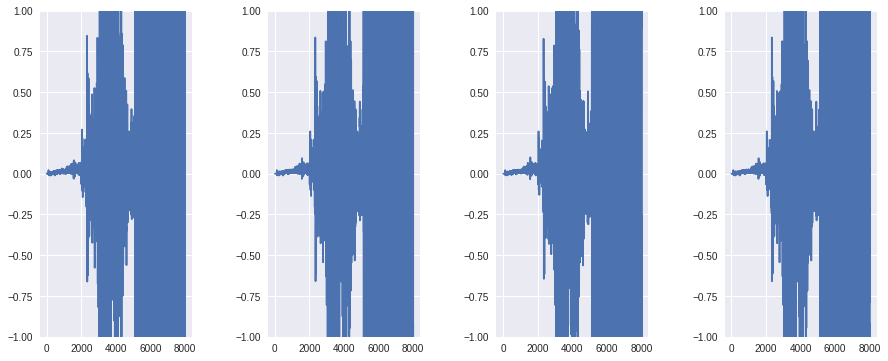

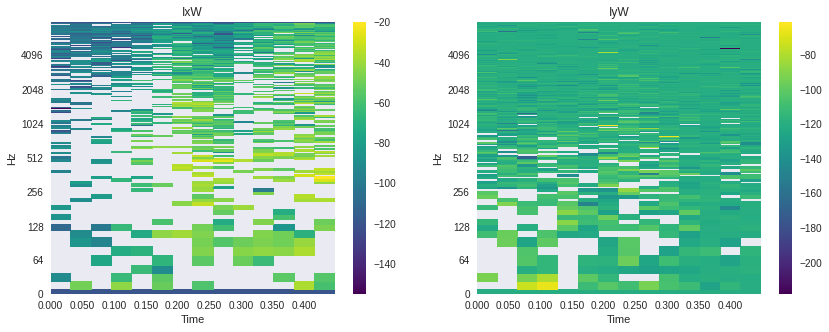

In [76]:
p_0, p_1, p_2, p_3 = stringToSignal(class_15)
# Inspect one audio
plt.figure(figsize=(15,6))
plt.subplot(1,4,1)
plt.plot(p_0[30])
plt.ylim(-1, 1)
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.5)
plt.subplot(1,4,2)
plt.plot(p_1[30])
plt.ylim(-1, 1)
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.5)
plt.subplot(1,4,3)
plt.plot(p_2[30])
plt.ylim(-1, 1)
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.5)
plt.subplot(1,4,4)
plt.plot(p_3[30])
plt.ylim(-1, 1)
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.5)

IxW, IyW = featureExtractor(p_0, p_1, p_2, p_3)
# Inspect one feature
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
librosa.display.specshow(20*np.log10(IxW[30] + 1e-6), sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar()
plt.title('IxW')
plt.subplot(1,2,2)
librosa.display.specshow(20*np.log10(IyW[30] + 1e-6), sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar()
plt.title('IyW')


In [77]:
print(np.shape(p_0))
print(np.shape(p_0[0]))
print(np.shape(librosa.stft(p_0[0])))
print(np.shape(librosa.stft(p_0[0], n_fft = 1024)))
print(np.shape(librosa.stft(p_0[0], n_fft = 1024, hop_length = 512)))
print(np.shape(librosa.stft(p_0[0], n_fft = 1024, hop_length = 512)))
print(np.shape(librosa.stft(p_0[0], n_fft = 1024, hop_length = 512, center=False)))
print(np.shape(librosa.stft(p_0[0], n_fft = 1024, hop_length = 512)))

(60, 8000)
(8000,)
(1025, 16)
(513, 32)
(513, 16)
(513, 16)
(513, 14)
(513, 16)


In [78]:
(np.asarray(IxW).shape)

(60, 513, 14)

In [79]:
ipd.display(ipd.Audio(p_3[50], rate=sr))
print(len(p_0))
print(len(p_0[10]))

60
8000


In [80]:

# Averaging Micropone signals to get the pressure at the origin
signals_len = len(p_0)
p0 = []
for i in range(signals_len):
  p0.append((p_0[i] + p_1[i] + p_2[i] + p_3[i])/4)

In [81]:
ipd.display(ipd.Audio(p0[50], rate=sr))
print(len(p0))
print(len(p0[10]))

60
8000


In [82]:
print(signals_len)
print(np.asarray(p_0).shape)


60
(60, 8000)


According to the theory on Sound Intensity (SI), only the real part (active intensity vector) contains the location information of a sound source.

In [83]:
print(np.asarray(IxW).shape)
print(np.asarray(IxW[0]).shape)

(60, 513, 14)
(513, 14)


## Subarrays


Actually, only three microphones are enough to estimate the SI by forming two rothogonal first-order DMAs with a shared microphone.

A = 2,1,4
B = 3,2,1
C = 4,3,2
D = 1,4,3

A) case (1 shared)

2,1 form  the first-order DMA along the direction 3π/4 and 4,1 along the direction -3π/4.

In [84]:
def featureExtractorSubArrays(a, b, c):
  # STFT 3-1 for x axis, 4 -2 for y axis <- velocity
  d = 0.04
  ro = 1.225
  Vx = []
  Vy = []
  signals_len = len(p_0)
  sqrt2 = np.sqrt(2)
  for i in range(signals_len):
    Vx.append(sqrt2 * (librosa.stft(c[i], n_fft = 1024, hop_length = 512, center=False) - librosa.stft(b[i], n_fft = 1024, hop_length = 512, center=False)).imag / (d*ro))
    Vy.append(sqrt2 * (librosa.stft(b[i], n_fft = 1024, hop_length = 512, center=False) - librosa.stft(a[i], n_fft = 1024, hop_length = 512, center=False)).imag / (d*ro))
  
  # I can simply do the average of the STFT
  A = []
  B = []
  C = []
  P0 = []
  for i in range(signals_len):
    A.append(librosa.stft(a[i], n_fft = 1024, hop_length = 512, center=False))
    B.append(librosa.stft(b[i], n_fft = 1024, hop_length = 512, center=False))
    C.append(librosa.stft(c[i], n_fft = 1024, hop_length = 512, center=False))
    P0.append((A[i] + B[i] + C[i])/3)

  # I0x(omega,t) = P0(omega,t)*conj(Vx(omgea,t))
  I0x = []
  I0y = []
  for i in range(signals_len):
    I0x.append(P0[i]*Vx[i].conjugate())
    I0y.append(P0[i]*Vy[i].conjugate())

  # According to the theory on Sound Intensity (SI), only the real part (active 
  # intensity vector) contains the location information of a sound source.

  # Ix(omega,t) = Re{I0x(omgea,t)}
  Ix = []
  Iy = []
  for i in range(signals_len):
    Ix.append(I0x[i].real)
    Iy.append(I0y[i].real)

  # Whitening weighting 
  beta = 1e6
  W = []
  for i in range(signals_len):
    W.append((np.abs(P0[i])**2 + beta * (np.abs(Vx[i])**2 + np.abs(Vy[i])**2))**(1/2))

  # IxWeighted(omega,t) = Ix(omega,t)/weight
  IxW = []
  IyW = []
  for i in range(signals_len):
    IxW.append(Ix[i]/W[i])
    IyW.append(Iy[i]/W[i])

  return IxW, IyW

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


Text(0.5, 1.0, 'IxW_3πfourth_M0')

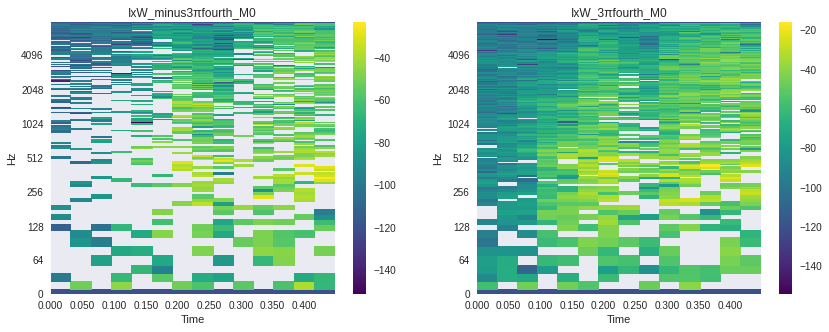

In [85]:
IxW_minus3πfourth_M0, IxW_3πfourth_M0 = featureExtractorSubArrays(p_1, p_0, p_3)
# Inspect one feature
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
librosa.display.specshow(20*np.log10(IxW_minus3πfourth_M0[30] + 1e-6), sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar()
plt.title('IxW_minus3πfourth_M0')
plt.subplot(1,2,2)
librosa.display.specshow(20*np.log10(IxW_3πfourth_M0[30] + 1e-6), sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar()
plt.title('IxW_3πfourth_M0')

B) case (2 shared)

1,2 form  the first-order DMA along the direction -π/4 and 3,2 along the direction -3π/4.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


Text(0.5, 1.0, 'IxW_minus3πfourth_M1')

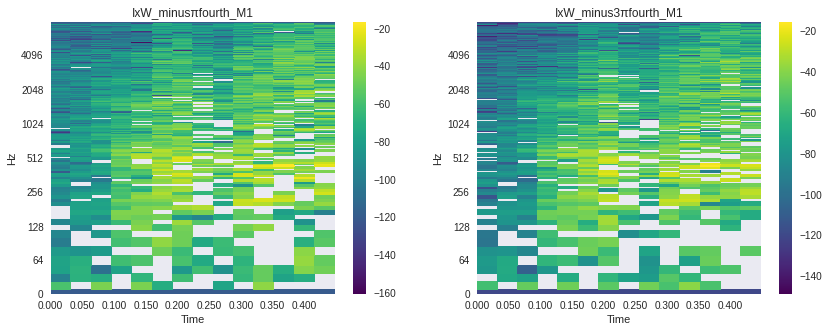

In [86]:
IxW_minusπfourth_M1, IxW_minus3πfourth_M1 = featureExtractorSubArrays(p_2, p_1, p_0)
# Inspect one feature
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
librosa.display.specshow(20*np.log10(IxW_minusπfourth_M1[30] + 1e-6), sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar()
plt.title('IxW_minusπfourth_M1')
plt.subplot(1,2,2)
librosa.display.specshow(20*np.log10(IxW_minus3πfourth_M1[30] + 1e-6), sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar()
plt.title('IxW_minus3πfourth_M1')

C) case (3 shared)

2,3 form  the first-order DMA along the direction π/4 and 4,3 along the direction -π/4.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


Text(0.5, 1.0, 'IxW_minusπfourth_M2')

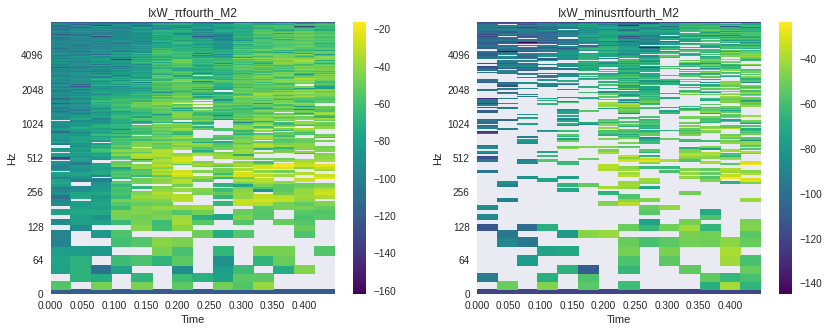

In [87]:
IxW_πfourth_M2, IxW_minusπfourth_M2 = featureExtractorSubArrays(p_3, p_2, p_1)
# Inspect one feature
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
librosa.display.specshow(20*np.log10(IxW_πfourth_M2[30] + 1e-6), sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar()
plt.title('IxW_πfourth_M2')
plt.subplot(1,2,2)
librosa.display.specshow(20*np.log10(IxW_minusπfourth_M2[30] + 1e-6), sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar()
plt.title('IxW_minusπfourth_M2')

D) case (4 shared)

1,4 form  the first-order DMA along the direction π/4 and 3,4 along the direction 3π/4.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


Text(0.5, 1.0, 'IxW_3πfourth_M3')

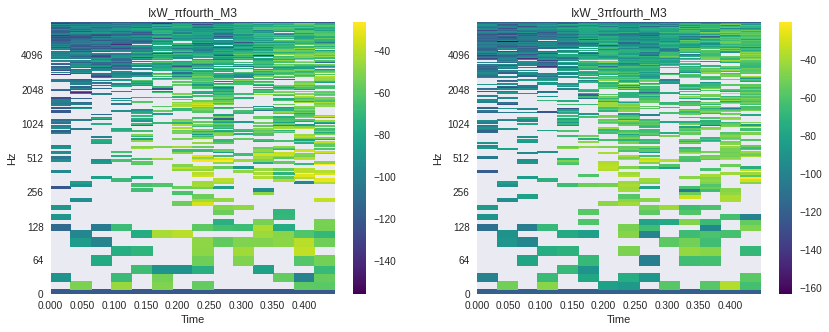

In [88]:
IxW_πfourth_M3, IxW_3πfourth_M3 = featureExtractorSubArrays(p_0, p_3, p_2)
# Inspect one feature
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
librosa.display.specshow(20*np.log10(IxW_πfourth_M3[30] + 1e-6), sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar()
plt.title('IxW_πfourth_M3')
plt.subplot(1,2,2)
librosa.display.specshow(20*np.log10(IxW_3πfourth_M3[30] + 1e-6), sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar()
plt.title('IxW_3πfourth_M3')

In [89]:
np.shape(IxW[i].T)

(14, 513)

In [90]:
len(IxW[0])

513

In [91]:
I_removed = IxW[0][1:1025]
print(len(I_removed))

512


In [92]:
print(np.shape(IxW_πfourth_M3))
print(np.shape(IxW_πfourth_M3[0]))
#print(np.shape(IxW_πfourth_M3[1][1])
A = np.asarray(IxW_πfourth_M3)
print(np.shape(A))
print(np.shape(A[0].T))
AA = A[0].T
print(np.shape(AA))

(60, 513, 14)
(513, 14)
(60, 513, 14)
(14, 513)
(14, 513)


## Summary of the features

Since the SI features at zero frequency are equal to 0 and hence contain no source location information, the SI features at zero frequency are discarded.

Moreover, considering the conjugate symmetrix property of the Fourier Transform, it suffices to utilize only the SI features over the frequency bins of positive frequencies.

In [93]:
print(np.shape(IxW_πfourth_M3))
print(np.shape(IxW_πfourth_M3[0]))
#print(np.shape(IxW_πfourth_M3[1][1])
A = np.asarray(IxW_πfourth_M3)
print(np.shape(A))
print(np.shape(A[0].T))
AA = A[0].T
print(np.shape(AA))

count = 0
A = np.asarray(IxW_πfourth_M3)
#for i in range(513):
#  if AA[0][i] < 0:
#    print('freq = {}'.format(AA[0][i]))
#    count = count + 1
#    print('counting count = {}'.format(count))
#    print('i = ', i)

#print('final count = {}'.format(count))

def keepPositive(I):
  I = np.asarray(I)
  IT = I.T

  #print(IT)
  #print(np.shape(IT))

  #print(IT[0])
  #print(np.shape(IT[0]))
  length0 = len(IT)
  II = []
  print('IT shape = ', np.shape(IT))
  print('IT[0] shape = ', np.shape(IT[0]))
  print('IT[0][0] = ', IT[0][0])
  for j in range(length0):
    length1 = len(IT[j])
    III = []
    for i in range(length1):
      if IT[j][i] > 0:
        III.append(IT[j][i])
    II.append(III)
  II = np.asarray(II)
  print('II shape = ', np.shape(II))
  print('III shape = ', np.shape(III))

  return II


(60, 513, 14)
(513, 14)
(60, 513, 14)
(14, 513)
(14, 513)


In [94]:
IP = keepPositive(IxW[0])

IT shape =  (14, 513)
IT[0] shape =  (513,)
IT[0][0] =  0.0
II shape =  (14,)
III shape =  (191,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [95]:
def GammaCreator(Gamma, I1, I2, I3, I4, I5, I6, I7, I8, I9, I10):

  #I1 = keepPositive(I1)
  Gamma[:, :, 0] = I1[1:512].T
  #I2 = keepPositive(I2)
  Gamma[:, :, 1] = I2[1:512].T
  #I3 = keepPositive(I3)
  Gamma[:, :, 2] = I3[1:512].T
  #I4 = keepPositive(I4)
  Gamma[:, :, 3] = I4[1:512].T
  #I5 = keepPositive(I5)
  Gamma[:, :, 4] = I5[1:512].T
  #I6 = keepPositive(I6)
  Gamma[:, :, 5] = I6[1:512].T
  #I7 = keepPositive(I7)
  Gamma[:, :, 6] = I7[1:512].T
  #I8 = keepPositive(I8)
  Gamma[:, :, 7] = I8[1:512].T
  #I9 = keepPositive(I9)
  Gamma[:, :, 8] = I9[1:512].T
  #I10 = keepPositive(I10)
  Gamma[:, :, 9] = I10[1:512].T

  return Gamma


In [96]:
np.shape(IxW[1])

(513, 14)

In [97]:
np.shape(IP)

(14,)

In [98]:
N = 14
M = 1024 # int(M/2 + 1) - 1
print(int(M/2) - 1)
C = 10
Gamma = np.empty([N, int(M/2) - 1, C], dtype = 'complex_')
Gamma_container = np.empty([signals_len, N, int(M/2) - 1, C], dtype = 'complex_')
int(M/2) - 1
for i in range(signals_len):
  Gamma_container[i] = GammaCreator(Gamma, IxW[i], IyW[i], IxW_minus3πfourth_M0[i], 
                                    IxW_3πfourth_M0[i], IxW_minusπfourth_M1[i], 
                                    IxW_minus3πfourth_M1[i], IxW_πfourth_M2[i], 
                                    IxW_minusπfourth_M2[i], IxW_πfourth_M3[i], 
                                    IxW_3πfourth_M3[i])

511


In [99]:
np.shape(Gamma_container)

(60, 14, 511, 10)

In [100]:
class_names12 = ['0', '30', '60', '90', '120', '150', '180', '210', '240', '270', '300', '330']
class_names36 = ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100', '110', '120', '130', '140', '150', '160', '170', '180', '190', '200', '210', '220', '230', '240', '250', '260', '270', '280', '290', '300', '310', '320', '330', '340', '350']


## Brief Data Exploration

In [101]:
# training set shape:
print('Training set audio dimension:',str(Gamma.shape))
class_15 = np.asarray(class_15)
print('Training set label dimension:',str(class_15.shape))

# test set shape:
#print('Test set audio dimension:',str(test_audio.shape))
#print('Test set label dimension:',str(test_labels.shape))

Training set audio dimension: (14, 511, 10)
Training set label dimension: (240,)


## Data Pre-Processing

Shouldn't we normalize the data in a range of 0 to 1 before feeding the data to the Neural Network model (?)

## Network Architecture

- Each convolutional layer uses 64 convolution kernels with the size of 3*3, to learn local correlations between local T-F regions.
- BN layer is used after each convolutional layer to improve the stability of the network and speed up the convergence of the network.
- The activation function of convolutional layers and fully connected layers is ReLU.
- Between the convolutional layer and the fully connected layer and after each fully connected layer, a droput procedure with rate 0.5 is used to avoid overfitting.
- size and number of convolutional kernels = . ? 
number of nodes in the fully connected layers = 512?.
- input = SI features
- The fully connected layer combines all the features extracted by the convolution layer to reduce the input 2D feature matrix to a 1D feature vector to facilitate the output layer for classification processing.
- SoftMax function is used to perform clssification
- The final source DOA is estimated by maximizing the posterior prbability 
- In the CNN training, the cross-entropy functon is used as the loss function
- We employ the Adam as the optimizer
- Initial learning rate is set to be 10^-3
- Maximum number of epochs = 100
- Early stopping with a patience of 10 epochs measured on the validation set is als used to prevent overfitting.



In [102]:
filters = 64
kernel_size = (3,3)
strides = (1,1)
input_shape = (14, 511, 10)
rate = 0.5
K = 36 # Then we will try also with K = 36

model = keras.Sequential ([
  #keras.layers.Input(shape=input_shape),
  # input layer (14 * 511 * 10) (convolutional layers + batch normalization (BN) w ReLU)                     
  keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, activation='relu', input_shape=input_shape, padding='valid', data_format = 'channels_last', use_bias = True, name='conv1'),
  keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=False, scale=False, beta_initializer="zeros", gamma_initializer="ones", moving_mean_initializer="zeros", moving_variance_initializer="ones", beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None, name = 'bn1'),
  # 2nd convolutional layers + batch normalization (BN) w ReLU
  keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, activation='relu', padding='valid', data_format = 'channels_last', use_bias = True, name='conv2'),
  keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=False, scale=False, beta_initializer="zeros", gamma_initializer="ones", moving_mean_initializer="zeros", moving_variance_initializer="ones", beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None, name = 'bn2'),
  # dropout procedure with rate 0.5
  tf.keras.layers.Dropout(rate, noise_shape=None, seed=None, name = 'dn1'),
  # 1st fully connected layer w ReLU & dropout procedure with rate 0.5
  keras.layers.Flatten(name='flatten'),
  tf.keras.layers.Dense(512, activation = 'relu', name = 'fc1'),
  tf.keras.layers.Dropout(rate, noise_shape=None, seed=None, name = 'dn2'),
  # 2nd fully connected layer w ReLU & dropout procedure with rate 0.5
  tf.keras.layers.Dense(512, activation = 'relu', name = 'fc2'),
  tf.keras.layers.Dropout(rate, noise_shape=None, seed=None, name = 'dn3'),
  # SoftMax
  #tf.keras.layers.Softmax()
  tf.keras.layers.Dense(K, activation = 'softmax', name = 'output'),
])

# keras.layers.Flatten(name='flatten'),?


In [103]:
# Let's show the architecture of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 12, 509, 64)       5824      
                                                                 
 bn1 (BatchNormalization)    (None, 12, 509, 64)       128       
                                                                 
 conv2 (Conv2D)              (None, 10, 507, 64)       36928     
                                                                 
 bn2 (BatchNormalization)    (None, 10, 507, 64)       128       
                                                                 
 dn1 (Dropout)               (None, 10, 507, 64)       0         
                                                                 
 flatten (Flatten)           (None, 324480)            0         
                                                                 
 fc1 (Dense)                 (None, 512)              

## Compiling the Model

In [104]:
learning_rate = 1e-3
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy' # sparse?
)

## Training the Model

In [105]:
y = model(Gamma_container)

In [106]:
y

<tf.Tensor: shape=(60, 36), dtype=float32, numpy=
array([[0.02775824, 0.02768934, 0.027868  , ..., 0.02780157, 0.02773548,
        0.0276827 ],
       [0.02776843, 0.02777405, 0.0277608 , ..., 0.02777761, 0.0277449 ,
        0.0278008 ],
       [0.02776952, 0.02777904, 0.02775368, ..., 0.02779965, 0.02772889,
        0.02785721],
       ...,
       [0.0278014 , 0.02778247, 0.02776421, ..., 0.027782  , 0.02776028,
        0.0278039 ],
       [0.0277834 , 0.02775689, 0.02779555, ..., 0.02776248, 0.02773738,
        0.02782094],
       [0.02776152, 0.02776092, 0.02775257, ..., 0.02778625, 0.0277645 ,
        0.0277932 ]], dtype=float32)>

In [107]:
len(class_15[0:240:4])
class_trainer = 15 * np.ones(60)
print(class_trainer)

[15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15.]


In [108]:
model.fit(Gamma_container, class_trainer, epochs=100)

Epoch 1/100


ValueError: ignored

## Evaluating Accuracy

In [ ]:
# Check how model performs on test dataset
test_loss, test_acc = model.evaluate(test_audio,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

## Predictions

In [ ]:
# Predictions over test set
predictions = model.predict(test_audio)

# Show result
audio_idx = 0 # Idx of image
print('Model output:',predictions[audio_idx])
print('Predicted label:', np.argmax(predictions[audio_idx]))
print('Ground truth label:',test_labels[audio_idx])

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [ ]:
num_rows = 5
num_cols = 3
num_audio = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_audio):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_audio)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()